# Deep Neural Network: Application

To build your Deep Neural Network forecasting model, you'll use the functions from the previous assignment to build a deep network. Hopefully, you'll see an improvement in accuracy over your previous logistic regression implementation.  

**After this assignment you will be able to:**

- Build and train a deep L-layer neural network, and apply it to supervised learning

Let's get started!

## Table of Contents
- [1 - Packages](#1)
- [2 - Load and Process the Dataset](#2)
- [3 - Model Architecture](#3)
    - [3.1 - 2-layer Neural Network](#3-1)
    - [3.2 - L-layer Deep Neural Network](#3-2)
    - [3.3 - General Methodology](#3-3)
- [4 - Two-layer Neural Network](#4)
    - [Exercise 1 - two_layer_model](#ex-1)
    - [4.1 - Train the model](#4-1)
- [5 - L-layer Neural Network](#5)
    - [Exercise 2 - L_layer_model](#ex-2)
    - [5.1 - Train the model](#5-1)
- [6 - Results Analysis](#6)
- [7 - References](#7)

<a name='1'></a>
## 1 - Packages

Begin by importing all the packages you'll need during this assignment. 

- [numpy](https://www.numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a library to plot graphs in Python.
- `dnn_app_utils_v3` provides the functions implemented in the "Building your Deep Neural Network: Step by Step" assignment to this notebook.
- `np.random.seed(1)` is used to keep all the random function calls consistent. It helps grade your work - so please don't change it! 

In [2]:
# Package imports
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy
from dnn_app_utils_v3 import *
from public_tests import *
np.random.seed(1)

<a name='2'></a>
# 2 - Load the Dataset and Normalization

In [4]:
# Loading the data 
input_data = pd.read_excel("Input for ANN_10year.xlsx")
input_data_2019 = pd.read_excel("Input for ANN.xlsx")
input_data = input_data.values   # .values converts a pandas dataframe to a numpy array 
input_data_2019 = input_data_2019.values

In [5]:
train_set_x_orig = input_data[:87600,1:8]
test_set_x_orig = input_data_2019[:8760,1:8]
train_set_y_orig = input_data[:87600,-1:]
test_set_y_orig = input_data_2019[:8760,-1:]

In [6]:
#Normalization process
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
train_set_x_normalized = scaler.fit_transform(train_set_x_orig)
test_set_x_normalized = scaler.fit_transform(test_set_x_orig)
train_set_y_normalized = scaler.fit_transform(train_set_y_orig)
test_set_y_normalized = scaler.fit_transform(test_set_y_orig)

#Transpose the data to put all features in the rows and all samples in the columns
train_set_x_normalized = train_set_x_normalized.T     # .T Transpose a numpy array  
test_set_x_normalized = test_set_x_normalized.T
train_set_y_normalized = train_set_y_normalized.T
test_set_y_normalized = test_set_y_normalized.T

In [7]:
m_train = train_set_x_orig.shape[0]
m_test = test_set_x_orig.shape[0]
print ("Number of training examples: m_train = " + str(m_train))
print ("Number of testing examples: m_test = " + str(m_test))
print ("train_set_x shape: " + str(train_set_x_normalized.shape))
print ("train_set_y shape: " + str(train_set_y_normalized.shape))
print ("test_set_x shape: " + str(test_set_x_normalized.shape))
print ("test_set_y shape: " + str(test_set_y_normalized.shape))

Number of training examples: m_train = 87600
Number of testing examples: m_test = 8760
train_set_x shape: (7, 87600)
train_set_y shape: (1, 87600)
test_set_x shape: (7, 8760)
test_set_y shape: (1, 8760)


<a name='3'></a>
## 3 - Model Architecture

<a name='3-1'></a>
### 3.1 - 2-layer Neural Network

Now that you're familiar with the dataset, it's time to build a deep neural network to forecast temperature!

You're going to build two different models:

- A 2-layer neural network
- An L-layer deep neural network

Then, you'll compare the performance of these models, and try out some different values for $L$. 

Let's look at the two architectures:

<img src="images/2layerNN.PNG" style="width:800px;height:400px;">
<div style="text-align:left; color:purple;">
    <b>Figure 2</b>: 2-layer neural network. <br>
    The model can be summarized as: INPUT -> LINEAR -> RELU -> LINEAR -> SIGMOID -> OUTPUT.
</div>

<u><b>Detailed Architecture of Figure 2</b></u>:
- The input is the historical data of 8 parameters.  
- The corresponding vector: $[x_0,x_1,...,x_{6}]^T$ is then multiplied by the weight matrix $W^{[1]}$ of size $(n^{[1]}, 7)$.
- Then, add a bias term and take its relu to get the following vector: $[a_0^{[1]}, a_1^{[1]},..., a_{n^{[1]}-1}^{[1]}]^T$.
- Repeat the same process.
- Multiply the resulting vector by $W^{[2]}$ and add the intercept (bias). 
- Finally, take the sigmoid of the result. 

<a name='3-2'></a>
### 3.2 - L-layer Deep Neural Network

It's pretty difficult to represent an L-layer deep neural network using the above representation. However, here is a simplified network representation:

<img src="images/LlayerNN.PNG" style="width:800px;height:400px;">
<div style="font-weight:bold; color:purple;">
    Figure 3: L-layer neural network. <br>
    The model can be summarized as: [LINEAR -> RELU] $\times$ (L-1) -> LINEAR -> SIGMOID
</div>

<u><b>Detailed Architecture of Figure 3</b></u>:
- The input is the historical data of 8 parameters.
- The corresponding vector: $[x_0,x_1,...,x_{6}]^T$ is then multiplied by the weight matrix $W^{[1]}$ and then you add the intercept $b^{[1]}$. The result is called the linear unit.
- Next, take the relu of the linear unit. This process could be repeated several times for each $(W^{[l]}, b^{[l]})$ depending on the model architecture.
- Finally, take the sigmoid of the final linear unit. 

<a name='3-3'></a>
### 3.3 - General Methodology

As usual, you'll follow the Deep Learning methodology to build the model:

1. Initialize parameters / Define hyperparameters
2. Loop for num_iterations:
    a. Forward propagation
    b. Compute cost function
    c. Backward propagation
    d. Update parameters (using parameters, and grads from backprop) 
3. Use trained parameters to predict labels

Now go ahead and implement those two models!

<a name='4'></a>
## 4 - Two-layer Neural Network

<a name='ex-1'></a>
### Exercise 1 - two_layer_model 

Use the helper functions you have implemented in the previous assignment to build a 2-layer neural network with the following structure: *LINEAR -> RELU -> LINEAR -> SIGMOID*. The functions and their inputs are:
```python
def initialize_parameters(n_x, n_h, n_y):
    ...
    return parameters 
def linear_activation_forward(A_prev, W, b, activation):
    ...
    return A, cache
def compute_cost(AL, Y):
    ...
    return cost
def linear_activation_backward(dA, cache, activation):
    ...
    return dA_prev, dW, db
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [8]:
### CONSTANTS DEFINING THE MODEL ####
n_x = 7     
n_h = 20
n_y = 1
layers_dims = (n_x, n_h, n_y)
learning_rate = 0.85

In [11]:
# GRADED FUNCTION: two_layer_model

def two_layer_model(X, Y, layers_dims, learning_rate = .85, num_iterations = 2000, print_cost=False):
    """
    Implements a two-layer neural network: LINEAR->RELU->LINEAR->SIGMOID.
    
    Arguments:
    X -- input data, of shape (n_x, number of examples)
    Y -- true "label" vector (containing 1 if cat, 0 if non-cat), of shape (1, number of examples)
    layers_dims -- dimensions of the layers (n_x, n_h, n_y)
    num_iterations -- number of iterations of the optimization loop
    learning_rate -- learning rate of the gradient descent update rule
    print_cost -- If set to True, this will print the cost every 100 iterations 
    
    Returns:
    parameters -- a dictionary containing W1, W2, b1, and b2
    """
    
    np.random.seed(1)
    grads = {}
    costs = []                              # to keep track of the cost
    m = X.shape[1]                           # number of examples
    (n_x, n_h, n_y) = layers_dims
    
    # Initialize parameters dictionary, by calling one of the functions you'd previously implemented
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters(n_x, n_h, n_y)
    # YOUR CODE ENDS HERE
    
    # Get W1, b1, W2 and b2 from the dictionary parameters.
    W1 = parameters["W1"]
    b1 = parameters["b1"]
    W2 = parameters["W2"]
    b2 = parameters["b2"]
    
    # Loop (gradient descent)

    for i in range(0, num_iterations):

        # Forward propagation: LINEAR -> RELU -> LINEAR -> SIGMOID. Inputs: "X, W1, b1, W2, b2". Output: "A1, cache1, A2, cache2".
        #(≈ 2 lines of code)
        # A1, cache1 = ...
        # A2, cache2 = ...
        # YOUR CODE STARTS HERE    
        A1, cache1 = linear_activation_forward(X, W1, b1, activation = "relu")
        A2, cache2 = linear_activation_forward(A1, W2, b2, activation = "sigmoid")
        # YOUR CODE ENDS HERE
        
        # Compute cost
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        cost = compute_cost(A2, Y)
        # YOUR CODE ENDS HERE
        
        # Initializing backward propagation
        dA2 = - (np.divide(Y, A2) - np.divide(1 - Y, 1 - A2))
        
        # Backward propagation. Inputs: "dA2, cache2, cache1". Outputs: "dA1, dW2, db2; also dA0 (not used), dW1, db1".
        #(≈ 2 lines of code)
        # dA1, dW2, db2 = ...
        # dA0, dW1, db1 = ...
        # YOUR CODE STARTS HERE  
        dA1, dW2, db2 = linear_activation_backward(dA2, cache2, activation = "sigmoid")
        dA0, dW1, db1 = linear_activation_backward(dA1, cache1, activation = "relu")
        # YOUR CODE ENDS HERE
        
        # Set grads['dWl'] to dW1, grads['db1'] to db1, grads['dW2'] to dW2, grads['db2'] to db2
        grads['dW1'] = dW1
        grads['db1'] = db1
        grads['dW2'] = dW2
        grads['db2'] = db2
        
        # Update parameters.
        #(approx. 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE
        parameters = update_parameters(parameters, grads, learning_rate)
        # YOUR CODE ENDS HERE

        # Retrieve W1, b1, W2, b2 from parameters
        W1 = parameters["W1"]
        b1 = parameters["b1"]
        W2 = parameters["W2"]
        b2 = parameters["b2"]
        
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)

    return parameters, costs

def plot_costs(costs, learning_rate):
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per hundreds)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()

Complete previous cell and run the following cell to answer Exercise 1 on CANVAS. 

In [12]:
parameters, costs = two_layer_model(train_set_x_normalized, train_set_y_normalized, layers_dims = (n_x, n_h, n_y), num_iterations = 1, print_cost=False)

print("Cost after first iteration: " + str(costs[0]))

Cost after iteration 0: 0.6931252443010859
Cost after first iteration: 0.6931252443010859


<a name='4-1'></a>
### 4.1 - Train the model 

If your code passed the previous cell, run the cell below to train your parameters. 

- The cost should decrease on every iteration. 

- It may take some minutes to run 1000 iterations. 

Cost after iteration 1999: 0.6028627717259525


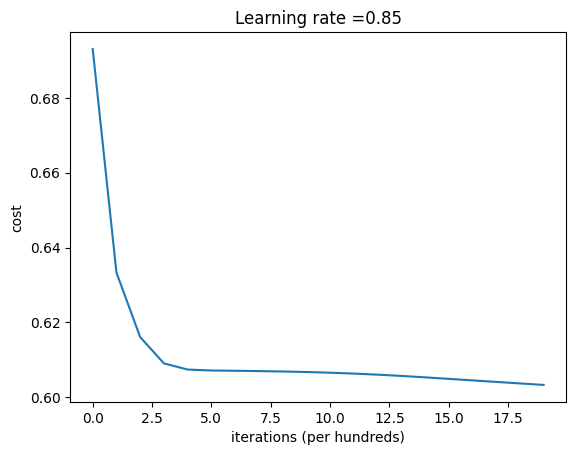

In [13]:
parameters, costs = two_layer_model(train_set_x_normalized, train_set_y_normalized, layers_dims = (n_x, n_h, n_y), num_iterations = 2000, print_cost=False)
plot_costs(costs, learning_rate)

You successfully trained the model. Good thing you built a vectorized implementation! Otherwise it might have taken 10 times longer to train this.

Now, you can use the trained parameters to forecast temperature. To see your predictions on the training and test sets, run the cell below.

In [14]:
predictions_train = predict(train_set_x_normalized, train_set_y_normalized, parameters)

Accuracy: 93.89970098920335


In [15]:
predictions_test = predict(test_set_x_normalized, test_set_y_normalized, parameters)

Accuracy: 88.4192535674812


In [16]:
#Reverse normalization
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Reverse the normalization to get the original data
Y_prediction_test_real_scale = scaler.inverse_transform(predict(test_set_x_normalized, test_set_y_normalized, parameters))

Accuracy: 88.4192535674812


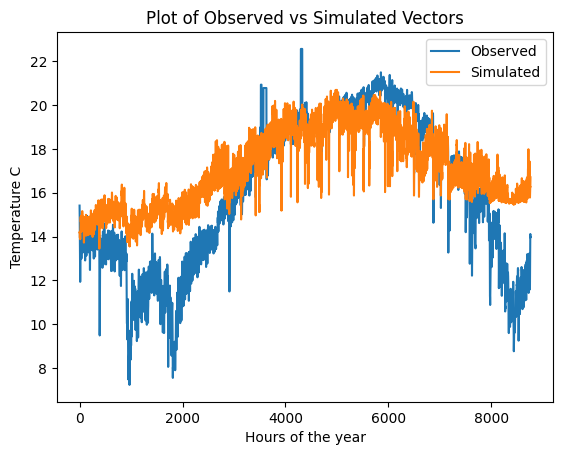

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Define the two vectors

x = np.arange(0,8760, 1)
y1 = test_set_y_orig   
y2 = Y_prediction_test_real_scale.T

# Plot the vectors
plt.plot(x, y1, label='Observed')
plt.plot(x, y2, label='Simulated')

# Add a title and labels for the x and y axes
plt.title('Plot of Observed vs Simulated Vectors')
plt.xlabel('Hours of the year')
plt.ylabel('Temperature C')

# Add a legend
plt.legend()

# Display the plot
plt.show()

<a name='5'></a>
## 5 - L-layer Neural Network

<a name='ex-2'></a>
### Exercise 2 - L_layer_model 

Use the helper functions you implemented previously to build an $L$-layer neural network with the following structure: *[LINEAR -> RELU]$\times$(L-1) -> LINEAR -> SIGMOID*. The functions and their inputs are:
```python
def initialize_parameters_deep(layers_dims):
    ...
    return parameters 
def L_model_forward(X, parameters):
    ...
    return AL, caches
def compute_cost(AL, Y):
    ...
    return cost
def L_model_backward(AL, Y, caches):
    ...
    return grads
def update_parameters(parameters, grads, learning_rate):
    ...
    return parameters
```

In [18]:
### CONSTANTS ###
layers_dims = [7, 20, 10, 5, 1] #  4-layer model

In [19]:
# GRADED FUNCTION: L_layer_model

def L_layer_model(X, Y, layers_dims, learning_rate = 0.85, num_iterations = 3000, print_cost=False):
    """
    Implements a L-layer neural network: [LINEAR->RELU]*(L-1)->LINEAR->SIGMOID.
    
    Arguments:
    X -- data, numpy array of shape (num_px * num_px * 3, number of examples)
    Y -- true "label" vector (containing 0 if cat, 1 if non-cat), of shape (1, number of examples)
    layers_dims -- list containing the input size and each layer size, of length (number of layers + 1).
    learning_rate -- learning rate of the gradient descent update rule
    num_iterations -- number of iterations of the optimization loop
    print_cost -- if True, it prints the cost every 100 steps
    
    Returns:
    parameters -- parameters learnt by the model. They can then be used to predict.
    """

    np.random.seed(1)
    costs = []                         # keep track of cost
    
    # Parameters initialization.
    #(≈ 1 line of code)
    # parameters = ...
    # YOUR CODE STARTS HERE
    parameters = initialize_parameters_deep(layers_dims)
    # YOUR CODE ENDS HERE
    
    # Loop (gradient descent)
    for i in range(0, num_iterations):

        # Forward propagation: [LINEAR -> RELU]*(L-1) -> LINEAR -> SIGMOID.
        #(≈ 1 line of code)
        # AL, caches = ...
        # YOUR CODE STARTS HERE
        AL, caches = L_model_forward(X, parameters)
        # YOUR CODE ENDS HERE
        
        # Compute cost.
        #(≈ 1 line of code)
        # cost = ...
        # YOUR CODE STARTS HERE
        cost = compute_cost(AL, Y)
        # YOUR CODE ENDS HERE
    
        # Backward propagation.
        #(≈ 1 line of code)
        # grads = ...    
        # YOUR CODE STARTS HERE
        grads = L_model_backward(AL, Y, caches)
        # YOUR CODE ENDS HERE
 
        # Update parameters.
        #(≈ 1 line of code)
        # parameters = ...
        # YOUR CODE STARTS HERE
        parameters = update_parameters(parameters, grads, learning_rate)
        
        # YOUR CODE ENDS HERE
                
        # Print the cost every 100 iterations
        if print_cost and i % 100 == 0 or i == num_iterations - 1:
            print("Cost after iteration {}: {}".format(i, np.squeeze(cost)))
        if i % 100 == 0 or i == num_iterations:
            costs.append(cost)
    
    return parameters, costs

Complete previous cell and run the following cell to answer Exercise 2 on CANVAS.

In [20]:
parameters, costs = L_layer_model(train_set_x_normalized, train_set_y_normalized, layers_dims, num_iterations = 1, print_cost = False)

print("Cost after first iteration: " + str(costs[0]))

Cost after iteration 0: 0.6876711597729944
Cost after first iteration: 0.6876711597729944


<a name='5-1'></a>
### 5.1 - Train the model 

If your code passed the previous cell, run the cell below to train your model as a 4-layer neural network. 

- The cost should decrease on every iteration. 

In [21]:
parameters, costs = L_layer_model(train_set_x_normalized, train_set_y_normalized, layers_dims, num_iterations = 3000, print_cost = False)

Cost after iteration 2999: 0.5968924114887803


In [22]:
pred_train = predict(train_set_x_normalized, train_set_y_normalized, parameters)

Accuracy: 95.4404453787442


In [23]:
pred_test = predict(test_set_x_normalized, test_set_y_normalized, parameters)

Accuracy: 92.54741585104283


### Congrats! It seems that your 4-layer neural network has better performance than your 2-layer neural network on the same test set. 

This is pretty good performance for this task. Nice job! 

In [24]:
#Reverse normalization
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Reverse the normalization to get the original data
Y_prediction_test_real_scale = scaler.inverse_transform(predict(test_set_x_normalized, test_set_y_normalized, parameters))

Accuracy: 92.54741585104283


<a name='6'></a>
##  6 - Results Analysis

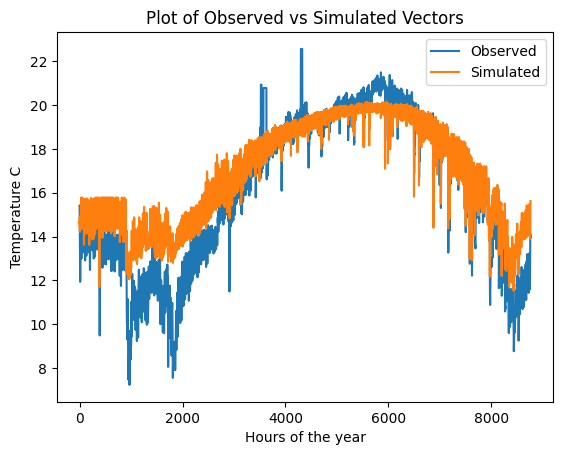

In [25]:
import matplotlib.pyplot as plt
import numpy as np

# Define the two vectors

x = np.arange(0,8760, 1)
y1 = test_set_y_orig   
y2 = Y_prediction_test_real_scale.T

# Plot the vectors
plt.plot(x, y1, label='Observed')
plt.plot(x, y2, label='Simulated')

# Add a title and labels for the x and y axes
plt.title('Plot of Observed vs Simulated Vectors')
plt.xlabel('Hours of the year')
plt.ylabel('Temperature C')

# Add a legend
plt.legend()

# Display the plot
plt.show()

<a name='7'></a>
##  7 - References
- Speech and Language Processing. Daniel Jurafsky & James H. Martin. Draft of January 7, 2023.Chapter 5, Logistic Regression
- https://www.deeplearning.ai/
- http://www.wildml.com/2015/09/implementing-a-neural-network-from-scratch/